# Mastering MultiIndexes in Pandas: A Powerful Tool for Complex Data Analysis

Pandas is one of the most popular data manipulation libraries for one of the most popular programming languages right now: Python. Pandas has proven to be a very useful tool in many applications, spanning multiple industries and many practical use cases. In this blog post, we'll take a closer look at one of the key features pandas offers for handling more complex, multidimensional data sets: MultiIndexes or hierarchical indexes.

## What is a MultiIndex?

A MultiIndex, also known as a hierarchical index, is a pandas data structure that enables indexing and accessing data across multiple dimensions or levels. It allows you to define multiple index levels for rows and columns, creating a hierarchical structure for the data. Let's clarify this with an example. Say you're a personal trainer and you want to monitor key health parameters of one of your clients during his/her sport activities. There are several parameters you'd like to monitor, like heart rate, running pace, cadence and you'd like to monitor them all over the time interval of the sports activity.

Let's write some python code that can manipulate this type of data for you. First, let's start by writing some functions that will help up simulate health performance data such as heart rates and running cadences:

In [1]:
from __future__ import annotations
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

start = datetime(2023, 6, 8, 14)
end = start + timedelta(hours=1, minutes=40)
timestamps = pd.date_range(start, end, freq=timedelta(minutes=1), inclusive='left')


def get_heart_rate(begin_hr: int, end_hr: int, break_point: int) -> pd.Series[float]:
    noise = np.random.normal(loc=0.0, scale=3, size=100)
    heart_rate = np.concatenate((np.linspace(begin_hr, end_hr, num=break_point), [end_hr] * (100 - break_point))) + noise
    return pd.Series(data=heart_rate, index=timestamps)


def get_cadence(mean_cadence: int) -> pd.Series[float]:
    noise = np.random.normal(loc=0.0, scale=1, size=100)
    cadence = pd.Series(data=[mean_cadence] * 100 + noise, index=timestamps)
    cadence[::3] = np.NAN
    cadence[1::3] = np.NAN
    return cadence.ffill().fillna(mean_cadence)

The code begins with the necessary imports, including the datetime module from the Python standard library, as well as numpy and pandas libraries.

Next up, we consider a sports activity of 1 hour and 40 minutes, or 100 minutes in total. The pd.date_range function is used to generate a series of timestamps at one-minute intervals from the start to the end time.

The `get_heart_rate` function generates synthetic heart rate data. It supposes that athletes linearly increase their heart rate until a certain level, and maintain that constant level for the rest of the activity. Gaussian noise is added to create more realistic heart rate data.

For the synthetic cadence data, generated by the `get_cadence` function, a more or less constant cadence is assumed throughout the activity. Gaussian noise is again added, but as the cadence is more stable than heart rates, noise values are only changed every three minutes instead of every minute as was the case in the `get_heart_rate` function.

Now, we're ready to create some synthetic data! Let's consider two different athletes: Bob and Alice.

In [2]:
bob_hr = get_heart_rate(begin_hr=110, end_hr=160, break_point=20)
alice_hr = get_heart_rate(begin_hr=90, end_hr=140, break_point=50)
bob_cadence = get_cadence(mean_cadence=175)
alice_cadence = get_cadence(mean_cadence=165)

At this point, we have the heart rates and cadences of Bob and Alice. Let's plot them using matplotlib to get some more insight into the data:

(158.0, 180.0)

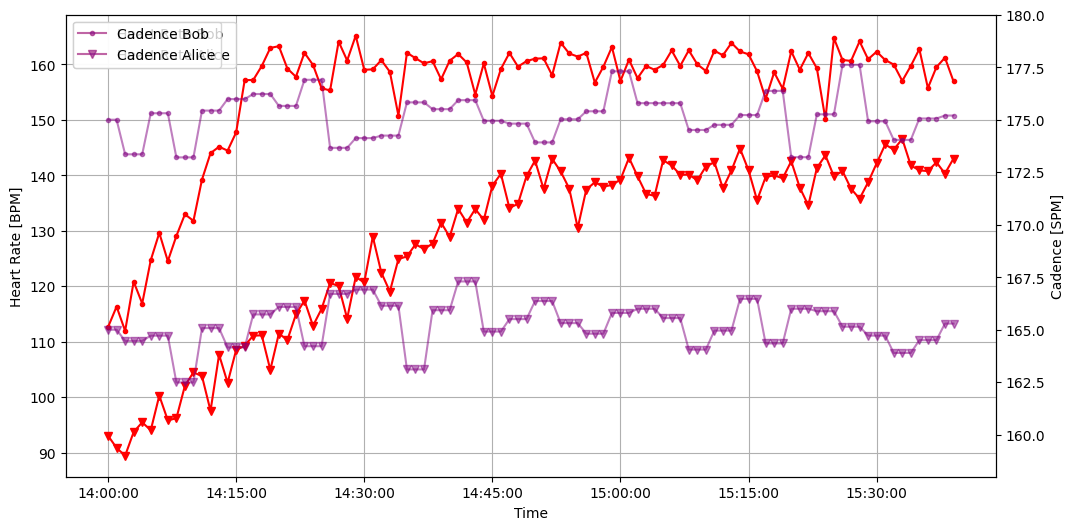

In [ ]:
from __future__ import annotations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


date_formatter = mdates.DateFormatter('%H:%M:%S')  # Customize the date format as needed

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(date_formatter)
ax.plot(bob_hr, color="red", label="Heart Rate Bob", marker=".")
ax.plot(alice_hr, color="red", label="Heart Rate Alice", marker="v")
ax.grid()
ax.legend()
ax.set_ylabel("Heart Rate [BPM]")
ax.set_xlabel("Time")


ax_cadence = ax.twinx()
ax_cadence.plot(bob_cadence, color="purple", label="Cadence Bob", marker=".", alpha=0.5)
ax_cadence.plot(alice_cadence, color="purple", label="Cadence Alice", marker="v", alpha=0.5)
ax_cadence.legend()
ax_cadence.set_ylabel("Cadence [SPM]")
ax_cadence.set_ylim(158, 180)

Nice! We can easily see how Bob has a higher maximum heart rate and a quicker ramp-up of that heart rate compared to alice. We can also see that Bob's cadence is significantly higher than Alice's cadence.

You might have noticed how we use four different variables to display two different health parameters of two athletes: `bob_hr`, `alice_hr`, `bob_cadence` and `alice_cadence`. In more realistic applications, the amount of health parameters and athletes will both increase significantly, so creating new variables for each athlete is a bad idea. Let's see how we can use pandas to improve this! Our first instinct is to use a pd.DataFrame instead of a pd.Series per athlete to represent all his/her health parameters:

In [ ]:
bob_df = pd.concat([bob_hr.rename("heart_rate"), bob_cadence.rename("cadence")], axis="columns")
print(bob_df.to_markdown())

That looks better already! But now we still have to create a new dataframe for each athlete. This is where pandas MultiIndex can help. Let's take a look at how we can elegantly merge the data of multiple athletes and health parameters into one dataframe.

In [ ]:
from itertools import product
bob_df = bob_hr.to_frame("value")
bob_df["athlete"] = "Bob"
bob_df["parameter"] = "heart_rate"

values = {
    "Bob": {
        "heart_rate": bob_hr,
        "cadence": bob_cadence,
    },
    "Alice": {
        "heart_rate": alice_hr,
        "cadence": alice_cadence
    }
}

sub_dataframes: list[pd.DataFrame] = []
for athlete, parameter in product(["Bob", "Alice"], ["heart_rate", "cadence"]):
    sub_df = values[athlete][parameter].to_frame("values")
    sub_df["athlete"] = athlete
    sub_df["parameter"] = parameter
    sub_dataframes.append(sub_df)

df = pd.concat(sub_dataframes).set_index(["athlete", "parameter"], append=True)
df.index = df.index.set_names(["timestamps", "athlete", "parameter"])
print(df.to_markdown())

At this point, we have got ourselves a single dataframe that holds all information for an arbitrary amount of athletes and health parameters. We can now easily use the `.xs` method to query the hierarchical dataframe:

In [ ]:
print(df.xs("Bob", level="athlete").head().to_markdown())  # get all health data for Bob

In [ ]:
print(df.xs("heart_rate", level="parameter").head().to_markdown())  # get all heart rates

In [ ]:
print(df.xs("Bob", level="athlete").xs("heart_rate", level="parameter").head().to_markdown())  # get heart_rate data for Bob

## Use Case: Earth Temperature Changes

Let's use hierarchical dataframes for a more realistic and complex use case: change in earth surface temperatures over the last decades. For this purpose, we'll use a dataset availabel on Kaggle (https://www.kaggle.com/datasets/sevgisarac/temperature-change?datasetId=1056827&sortBy=voteCount) summarizing Global Surface Temperature Change data distributed by the National Aeronautics and Space Administration Goddard Institute for Space Studies (NASA-GISS). Let's read and inspect the data first.

In [ ]:
from pathlib import Path

environment_data = Path() / "data" / "Environment_Temperature_change_E_All_Data_NOFLAG.csv"
df = pd.read_csv(environment_data, encoding='cp1252')
print(df.describe().to_markdown())

From this first inspection, we see how data is organized all into one dataframe, with different rows for different months and countries, but values for the different years are provided into the several columns in the dataframe starting with a 'Y'. This is very difficult to read and to use for data visualization purposes, so let's try and convert this data into a nice hierarchical dataframe so we can easily use it to query and visualize data.

In [ ]:
from dataclasses import dataclass, field
from datetime import date
from pydantic import BaseModel

MONTHS = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7, "August": 8,
          "September": 9, "October": 10,
          "November": 11, "December": 12}


class GistempDataElement(BaseModel):
    area: str
    timestamp: date
    value: float


@dataclass
class GistempTransformer:
    temperature_changes: list[GistempDataElement] = field(default_factory=list)
    standard_deviations: list[GistempDataElement] = field(default_factory=list)

    def _process_row(self, row) -> None:
        relevant_elements = ["Temperature change", "Standard Deviation"]
        if (element := row["Element"]) not in relevant_elements or (month := MONTHS.get(row["Months"])) is None:
            return None

        for year, value in row.filter(regex="Y.*").items():
            new_element = GistempDataElement(
                timestamp=date(year=int(year.replace("Y", "")), month=month, day=1),
                area=row["Area"],
                value=value
            )
            if element == "Temperature change":
                self.temperature_changes.append(new_element)
            else:
                self.standard_deviations.append(new_element)

    @property
    def df(self) -> pd.DataFrame:
        temp_changes_df = pd.DataFrame.from_records([elem.dict() for elem in self.temperature_changes])
        temp_changes = temp_changes_df.set_index(["timestamp", "area"]).rename(columns={"value": "temp_change"})

        std_deviations_df = pd.DataFrame.from_records([elem.dict() for elem in self.standard_deviations])
        std_deviations = std_deviations_df.set_index(["timestamp", "area"]).rename(columns={"value": "std_deviation"})

        return pd.concat([temp_changes, std_deviations], axis="columns")

    def process(self):
        environment_data = Path() / "data" / "Environment_Temperature_change_E_All_Data_NOFLAG.csv"
        df = pd.read_csv(environment_data, encoding='cp1252')
        df.apply(self._process_row, axis="columns")

This code showcases a `GistempTransformer` class that processes temperature data from a CSV file and creates a DataFrame with temperature changes and standard deviations.

The `GistempTransformer` dataclass contains two lists, `temperature_changes` and `standard_deviations`, to store the processed data elements. The `_process_row` method processes each row of the input DataFrame. It checks for relevant elements, such as "Temperature change" and "Standard Deviation," and extracts the month from the "Months" column. It then creates `GistempDataElement` instances and appends them to the respective lists based on the element type.

The `df` property returns a DataFrame by combining the temperature_changes and standard_deviations lists.

The process method reads the input CSV file, applies the `_process_row` method to each row of the DataFrame, and populates the temperature_changes and standard_deviations lists.

Let's use this transformer class to generate a hierarchical dataframe:

In [ ]:
transformer = GistempTransformer()
transformer.process()
df = transformer.df
print(df.head().to_markdown())

Now that we have consolidated all the relevant data into a single dataframe, we can proceed with inspecting and visualizing the data. Our focus is on examining the linear regression lines for each area, as they provide insights into the overall trend of temperature changes over the past decades. To facilitate this visualization, we will create a function that plots the temperature changes along with their corresponding regression lines.

In [ ]:
def plot_temperature_changes(areas: list[str]):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    for area in areas:
        df_country = df[df.index.get_level_values("area") == area].reset_index()
        dates = df_country["timestamp"].map(datetime.toordinal)
        gradient, offset = np.polyfit(dates, df_country.temp_change, deg=1)
        ax1.scatter(df_country.timestamp, df_country.temp_change, label=area, s=5)
        ax2.plot(df_country.timestamp, gradient * dates + offset, label=area)

    ax1.grid()
    ax2.grid()
    ax2.legend()
    ax2.set_ylabel("Regression Lines [°C]")
    ax1.set_ylabel("Temperature change [°C]")


And let's use this function to visualize temperature changes in the different continents:

In [ ]:
plot_temperature_changes(["Africa", "Antarctica", "Americas", "Asia", "Europe", "Oceania"])

From this plot, we can easily make different conclusions:

* the regression line for all continents has a positive gradient, confirming the global trend of increase in earth surface temperature
* the regression line for Europe is the steepest, indicating that temperature increase in Europe has been higher than in other continents, such as Antarctica. Although the exact reasons behind this require complex scientific research, it might be partly due to the different ocean currents: Europe is influenced by warm ocean currents, such as the Gulf Stream, which transport heat from the tropics towards the region. These currents help moderate temperatures and contribute to the relatively higher warming observed in Europe. In contrast, Antarctica is surrounded by cold ocean currents, and its climate is heavily influenced by the Southern Ocean and the Antarctic Circumpolar Current, which act as barriers to the incursion of warmer waters, limiting the warming effect.

Let's say now that we'd like to take a closer look into Europe itself. We can do this by creating the same plots for the different regions in Europe:

In [ ]:
plot_temperature_changes(["Southern Europe", "Eastern Europe", "Northern Europe", "Western Europe"])

From this figure, we can learn that temperature rises across the European continent are very similar, generally speaking. Eastern Europe has a slightly steeper regression line than for example Southern Europe, but no major differences can be observed.

Let's now say that we're interested in the top 10 countries that had the highest average temperature increase since the year 2000. Using the `get_level_values` method on a pandas MultiIndex, we can easily retrieve that list of countries as follows:

In [ ]:
print(df[df.index.get_level_values(level="timestamp") > date(2000, 1, 1)].groupby("area").mean().sort_values(by="temp_change",ascending=False).head(10).to_markdown())

This result matches with our previous findings that Europe was the continent where the rise in temperature was the highest.

Using the same method, we can also take a look at the ten countries that are least affected by the rise in temperature:

In [ ]:
print(df[df.index.get_level_values(level="timestamp") > date(2000, 1, 1)].groupby("area").mean().sort_values(by="temp_change",ascending=True).head(10).to_markdown())

We see that most of the countries in this list are small, remote islands based in the southern hemispher. So also here, this list of countries confirm the previous results where we found that southern continents, and Antarctica in particular are least affected by climate change.

Let's say we'd like to perform some more complex queries on the hierarchical dataframe. For this use case, we are interested in the temperature changes during the winters and summers. We'll assume that winters are composed of the months of December, January and February, while summers consist of June, July and August. This is how we can easily visualize the temperature changes of the summers and winters in Europe:

In [ ]:
all_winters = df[df.index.get_level_values(level="timestamp").map(lambda x: x.month in [12, 1, 2])]
all_summers = df[df.index.get_level_values(level="timestamp").map(lambda x: x.month in [6, 7, 8])]
winters_europe = all_winters.xs("Europe", level="area").sort_index()
summers_europe = all_summers.xs("Europe", level="area").sort_index()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(winters_europe.index, winters_europe.temp_change, label="Winters", marker="o", markersize=4)
ax.plot(summers_europe.index, summers_europe.temp_change, label="Summers", marker='o', markersize=4)
ax.grid()
ax.legend()
ax.set_ylabel("Temperature Change [°C]")

From this figure, it looks like temperature changes during the winters are much more volatile than temperature changes during the summers. Let's quantify this difference by calculating the standard deviation of the temperature changes during the winters and summers:

In [ ]:
print(pd.concat([winters_europe.std().rename("winters"), summers_europe.std().rename("summers")], axis="columns").to_markdown())